<a href="https://colab.research.google.com/github/johanhoffman/DD2365_VT24/blob/Sophiepitt_lab2/Sophiepitt_lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The Navier-Stokes equations**
**Johan Hoffman**

# **Abstract**

This short report show an example on how to use FEniCS to solve the Navier-Stokes equations, which is used in the course DD2365 Advanced Computation in Fluid Mechanics, at the KTH Royal Institute of Technology.

[DD2365 course website.](https://www.kth.se/social/course/DD2365/)

This study investigates the flow characteristics around a cylinder at various Reynolds numbers. Simulations are conducted for Reynolds numbers Re = 1, 10, 100 and 1000 to explore the transition between steady and unsteady flow regimes.

The drag and lift coefficients, along with the Strouhal number, are computed for each Reynolds number case. The analysis aims to verify the presence of a von Karman vortex street, characterized by a Strouhal number of approximately 0.2. The results confirm the expected behavior of the Strouhal number, providing validation for the presence of vortex shedding phenomena.

Furthermore, simulations are performed for Reynolds number Re = 100 under different mesh resolutions h = 1/8, 1/16 and 1/32. The investigation focuses on evaluating the impact of mesh resolution on the accuracy of the computed drag and lift coefficients and the Strouhal number and demonstrates the importance of mesh resolution in accurately predicting flow characteristics.

# **About the code**

In [ ]:
"""This program is an example file for the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [ ]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS (this may take a long time)
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt


# **Introduction**

The Navier-Stokes equations take the form

$\dot u + (u\cdot \nabla)u + \nabla p -\Delta u = f,\quad \nabla \cdot u=0,$

together with suitable initial and boundary conditions.

Here we present a FEniCS implementation of a stabilized space-time finite element method to solve the Navier-Stokes equations in 2D. The solution is visualized using FEniCS plotting functions, and is also exported as pvd-files which can be visualized in Paraview.

We seek a finite element approximation $(u,p)\in V\times Q$ such that

$(\dot u + (u\cdot \nabla)u, v) - (p,\nabla \cdot v) + (\nu \nabla u,\nabla v) + (\nabla \cdot u, q) + SD(u,p;v,q) = (f,v),$

for all test functions $(v,q) \in \hat V\times \hat Q$, where $SD(u,p;v,q)$ is a residual based stabilization term.

We present an example of flow past a circular cylinder, for which we compute the force on the surface of the cylinder $\Gamma$ in the direction $\phi$, by Green's formula:

$
F(u,p,\phi)= ~<\nu \nabla u\cdot n-pn, \Phi>_{\Gamma} ~=~(\dot u+(u\cdot \nabla)u, \Phi) + (\nu \nabla u,\nabla \Phi) - (p,\nabla \cdot\Phi)-(f,\Phi),
$

with $\Phi\in V$ a fuinction for which $\Phi\vert _{\Gamma}=\phi$ and $\Phi\vert_{\partial \Omega \setminus \Gamma}=0$. With $\phi=(1,0)$ we get the drag force $F_D$, and with $\phi=(0,1)$ the lift force $F_L$. The drag and lift coefficients are obtained by normalization,

$
c_D = \frac{2F_D}{\rho U^2D}, \quad c_L = \frac{2F_L}{\rho U^2D}
$

where $\rho$ is the density (here $\rho=1$), $U$ the characteristic velocity (here $U=1$), and $D$ the characteristic length scale (here $D$ is the diameter of the cylinder).

The Reynolds number is defined as $Re=\frac{UD}{\nu}$


The Strouhal number is defined as $St=\frac{fD}{U}$

To read more about how to use similar methods for more complex problems, see e.g.

[Hoffman, Johan, et al. "Towards a parameter-free method for high reynolds number turbulent flow simulation based on adaptive finite element approximation." Computer Methods in Applied Mechanics and Engineering 288 (2015): 60-74.](https://www.sciencedirect.com/science/article/pii/S0045782514004836)


# **Method**

**Define domain and mesh**

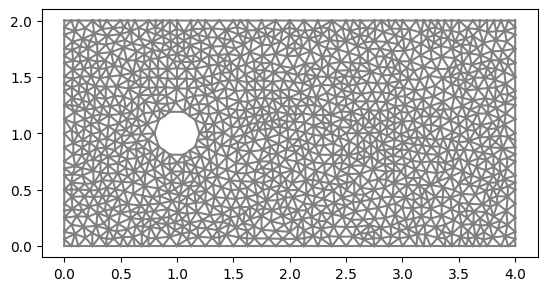

In [ ]:
# Define rectangular domain
L = 4
H = 2

# Define circle
xc = 1.0
yc = 0.5*H
rc = 0.2

# Define subdomains (for boundary conditions)
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0.0)

class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], L)

class Lower(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0)

class Upper(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], H)

left = Left()
right = Right()
lower = Lower()
upper = Upper()

# Generate mesh (examples with and without a hole in the mesh)
resolution = 32
#mesh = RectangleMesh(Point(0.0, 0.0), Point(L, H), L*resolution, H*resolution)
mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(xc,yc),rc), resolution)

# Local mesh refinement (specified by a cell marker)
no_levels = 0
for i in range(0,no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for cell in cells(mesh):
    cell_marker[cell] = False
    p = cell.midpoint()
    if p.distance(Point(xc, yc)) < 1.0:
        cell_marker[cell] = True
  mesh = refine(mesh, cell_marker)

# Define mesh functions (for boundary conditions)
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
boundaries.set_all(0)
left.mark(boundaries, 1)
right.mark(boundaries, 2)
lower.mark(boundaries, 3)
upper.mark(boundaries, 4)

plt.figure()
plot(mesh)
plt.show()

**Define finite element approximation spaces**

In [ ]:
# Generate finite element spaces (for velocity and pressure)
V = VectorFunctionSpace(mesh, "Lagrange", 1)
Q = FunctionSpace(mesh, "Lagrange", 1)

# Define trial and test functions
u = TrialFunction(V)
p = TrialFunction(Q)
v = TestFunction(V)
q = TestFunction(Q)

**Define boundary conditions**

In [ ]:
# Define boundary conditions
class DirichletBoundaryLower(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], 0.0)

class DirichletBoundaryUpper(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], H)

class DirichletBoundaryLeft(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0.0)

class DirichletBoundaryRight(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], L)

class DirichletBoundaryObjects(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (not near(x[0], 0.0)) and (not near(x[0], L)) and (not near(x[1], 0.0)) and (not near(x[1], H))

dbc_lower = DirichletBoundaryLower()
dbc_upper = DirichletBoundaryUpper()
dbc_left = DirichletBoundaryLeft()
dbc_right = DirichletBoundaryRight()
dbc_objects = DirichletBoundaryObjects()

# Examples of time dependent and stationary inflow conditions
#uin = Expression('4.0*x[1]*(1-x[1])', element = V.sub(0).ufl_element())
#uin = Expression('1.0 + 1.0*fabs(sin(t))', element = V.sub(0).ufl_element(), t=0.0)
uin = 1.0
bcu_in0 = DirichletBC(V.sub(0), uin, dbc_left)
bcu_in1 = DirichletBC(V.sub(1), 0.0, dbc_left)
bcu_upp0 = DirichletBC(V.sub(0), 0.0, dbc_upper)
bcu_upp1 = DirichletBC(V.sub(1), 0.0, dbc_upper)
bcu_low0 = DirichletBC(V.sub(0), 0.0, dbc_lower)
bcu_low1 = DirichletBC(V.sub(1), 0.0, dbc_lower)
bcu_obj0 = DirichletBC(V.sub(0), 0.0, dbc_objects)
bcu_obj1 = DirichletBC(V.sub(1), 0.0, dbc_objects)

pin = Expression('5.0*fabs(sin(t))', element = Q.ufl_element(), t=0.0)
pout = 0.0
#bcp0 = DirichletBC(Q, pin, dbc_left)
bcp1 = DirichletBC(Q, pout, dbc_right)

#bcu = [bcu_in0, bcu_in1, bcu_upp0, bcu_upp1, bcu_low0, bcu_low1, bcu_obj0, bcu_obj1]
bcu = [bcu_in0, bcu_in1, bcu_upp1, bcu_low1, bcu_obj0, bcu_obj1]
bcp = [bcp1]

# Define measure for boundary integration
ds = Measure('ds', domain=mesh, subdomain_data=boundaries)

# **Results**

**Define flow parameters**

In [ ]:
# Set viscosity
#nu = 4.0e-1    # Re = 1
#nu = 4.0e-2  # Re = 10
nu = 4.0e-3 # Re = 100
#nu = 4.0e-4    # Re = 1000

**Compute Reynlods Number**

In [ ]:
# Define Reynolds Number

Re = uin*2*rc / nu

print(Re)

10.0


**Define method parameters**

In [ ]:
# Define iteration functions
# (u0,p0) solution from previous time step
# (u1,p1) linearized solution at present time step
u0 = Function(V)
u1 = Function(V)
p0 = Function(Q)
p1 = Function(Q)

# Set parameters for nonlinear and lienar solvers
num_nnlin_iter = 5
prec = "amg" if has_krylov_solver_preconditioner("amg") else "default"

# Time step length
dt = 0.5*mesh.hmin()

**Define variational problem**

In [ ]:
# Define variational problem

# Stabilization parameters
h = CellDiameter(mesh);
u_mag = sqrt(dot(u1,u1))
d1 = 1.0/sqrt((pow(1.0/dt,2.0) + pow(u_mag/h,2.0)))
d2 = h*u_mag

# Mean velocities for trapozoidal time stepping
um = 0.5*(u + u0)
um1 = 0.5*(u1 + u0)

# Momentum variational equation on residual form
Fu = inner((u - u0)/dt + grad(um)*um1, v)*dx - p1*div(v)*dx + nu*inner(grad(um), grad(v))*dx \
    + d1*inner((u - u0)/dt + grad(um)*um1 + grad(p1), grad(v)*um1)*dx + d2*div(um)*div(v)*dx
au = lhs(Fu)
Lu = rhs(Fu)

# Continuity variational equation on residual form
Fp = d1*inner((u1 - u0)/dt + grad(um1)*um1 + grad(p), grad(q))*dx + div(um1)*q*dx
ap = lhs(Fp)
Lp = rhs(Fp)

**Compute force on boundary**

In this part, we change phi_x and phi_y to obtain or the lift or the drag coefficient. With $\phi=(1,0)$ we get the drag force $F_D$, and with $\phi=(0,1)$ the lift force $F_L$.

In [ ]:
# Define the direction of the force to be computed
phi_x = 0.0
phi_y = 1.0

#psi_expression = Expression(("0.0","pow(x[0]-0.5,2.0) + pow(x[1]-1.0,2.0) - pow(0.2,2.0) < 1.e-5 ? 1. : 0."), element = V.ufl_element())
psi_expression = Expression(("near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_x : 0.","near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_y : 0."), xc=xc, yc=yc, rc=rc, phi_x=phi_x, phi_y=phi_y, element = V.ufl_element())
psi = interpolate(psi_expression, V)

Force = inner((u1 - u0)/dt + grad(um1)*um1, psi)*dx - p1*div(psi)*dx + nu*inner(grad(um1), grad(psi))*dx

#plt.figure()
#plot(psi, title="weight function psi")

# Force normalization
D = 2*rc
normalization = -2.0/D


**Set plotting variables and open export files**

In [ ]:
# Open files to export solution to Paraview
file_u = File("results-NS/u.pvd")
file_p = File("results-NS/p.pvd")

# Set plot frequency
plot_time = 0
plot_freq = 10

# Force computation data
force_array = np.array(0.0)
force_array = np.delete(force_array, 0)
time = np.array(0.0)
time = np.delete(time, 0)
start_sample_time = 1.0

**Time stepping algorithm**

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_c384d9d017bcf4a7efe7798f43cda638e03aff41

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    2
  Coefficients:              '[f_96952, f_96955]'
  Unique elements:           'Vector<2 x CG1(?,?)>'
  Unique sub elements:       'Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 10
INFO:FFC:  quadrature_degree: 10
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0759814 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:---------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_dcc2baf12b2c99625d26a4409965075f59a364d6

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    3
  Coefficients:              '[f_96952, f_96955, f_96961]'
  Unique elements:           'Vector<2 x CG1(?,?)>, CG1(?,?)'
  Unique sub elements:       'Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 10
INFO:FFC:  quadrature_degree: 10
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0634751 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_eb1c849727ff567da07b1d3141b61c55ca14d369

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      0
  Arguments:                 '()'
  Number of coefficients:    4
  Coefficients:              '[f_96952, f_96955, f_96961, f_96965]'
  Unique elements:           'Vector<2 x CG1(?,?)>, CG1(?,?)'
  Unique sub elements:       'Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 2
INFO:FFC:  quadrature_degree: 2
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0520444 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:---

Time t = 0.03285506167650246


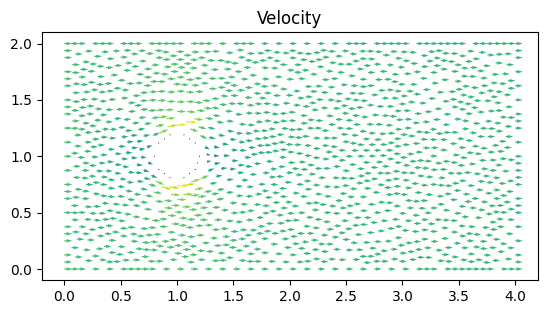

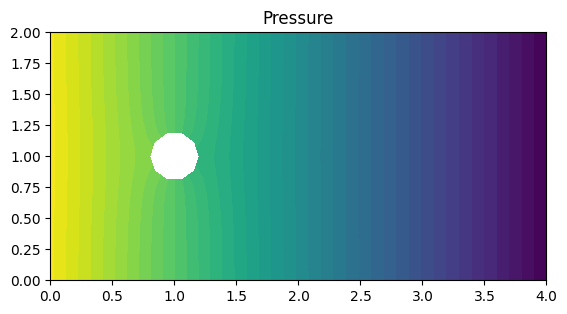

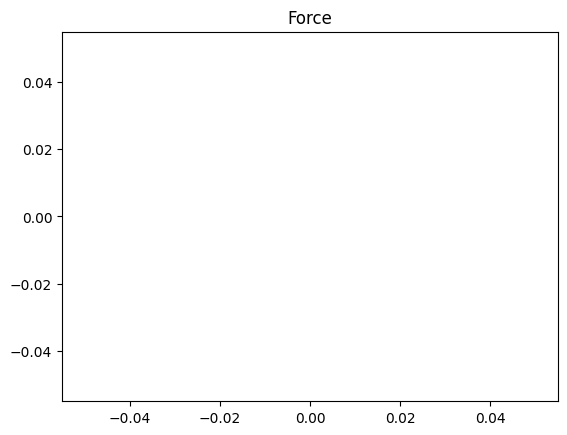

Time t = 3.022665674238231


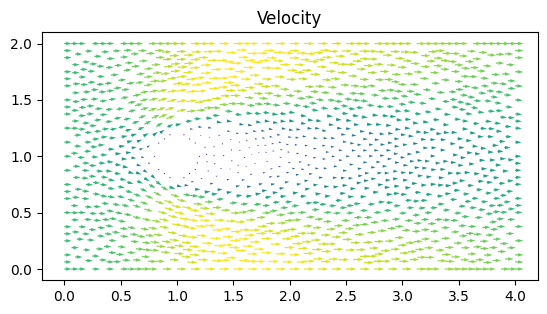

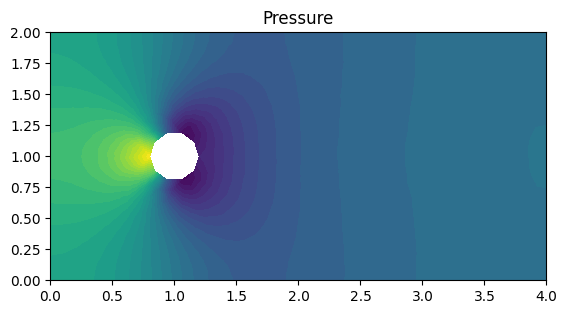

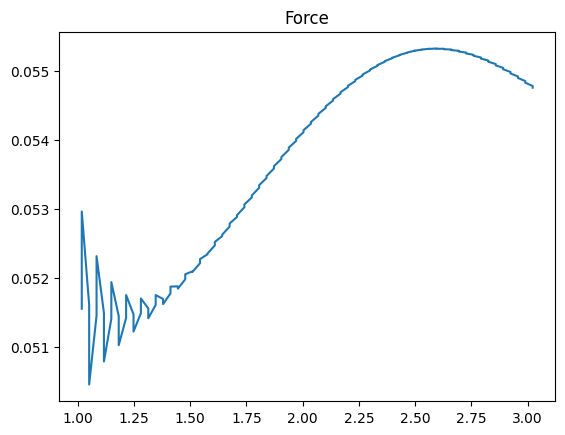

Time t = 6.012476286799972


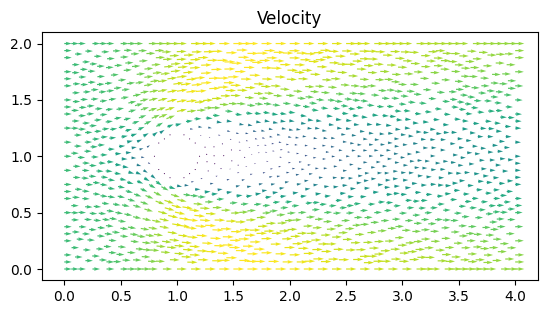

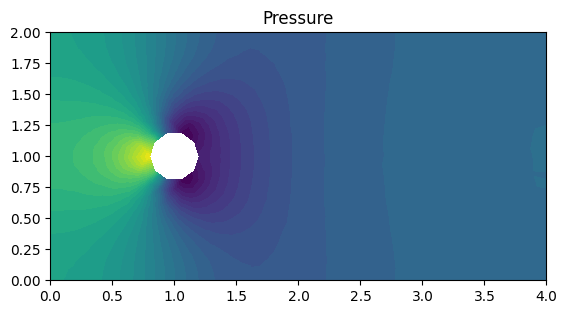

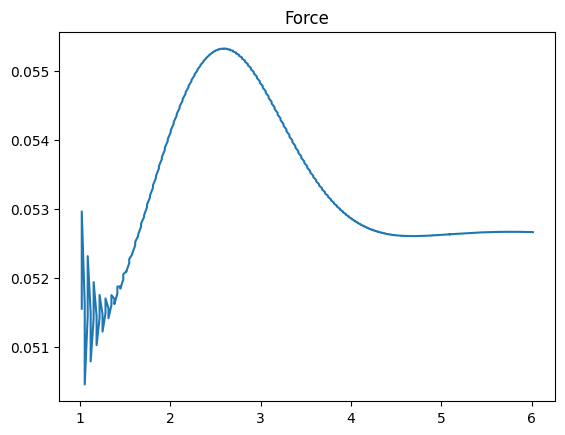

Time t = 9.002286899361685


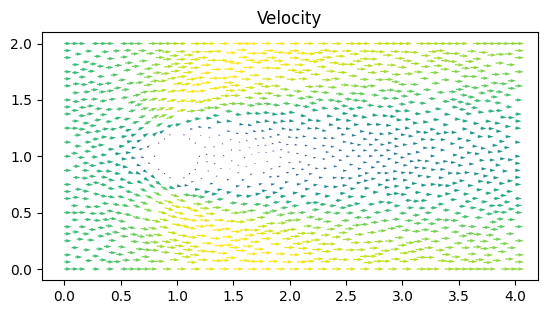

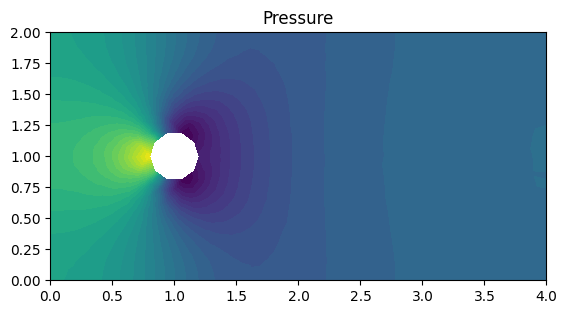

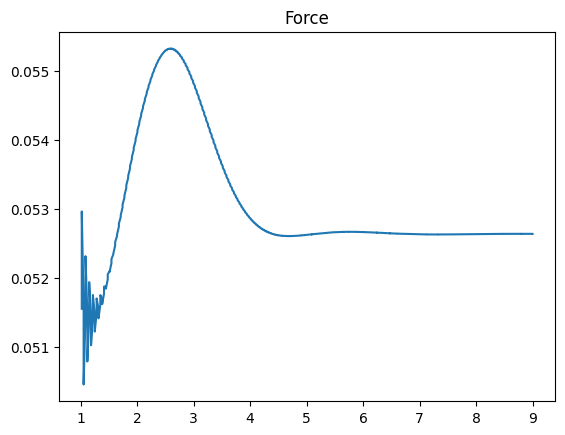

Time t = 12.024952573599847


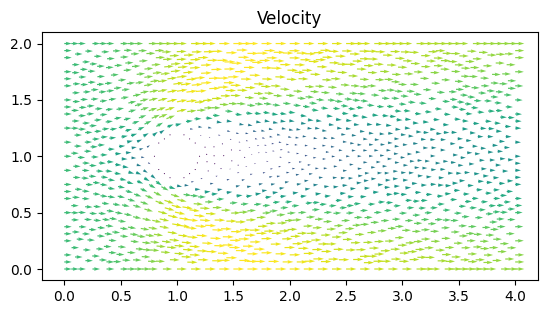

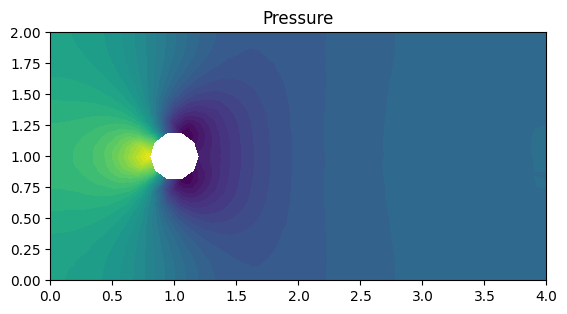

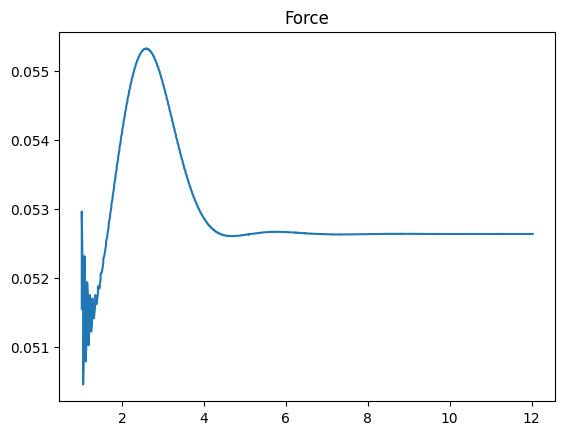

Time t = 15.014763186161508


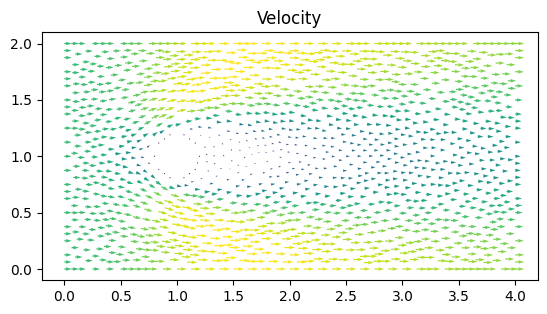

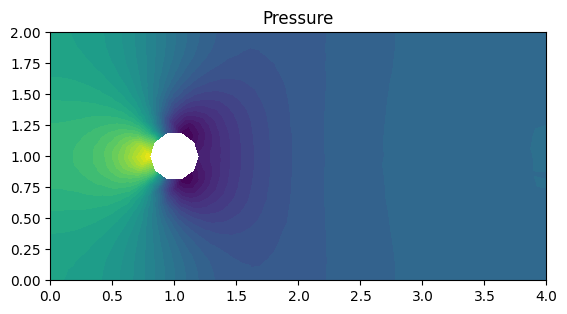

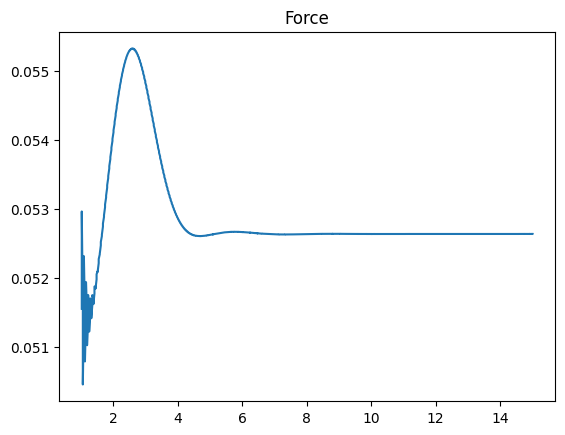

Time t = 18.00457379872328


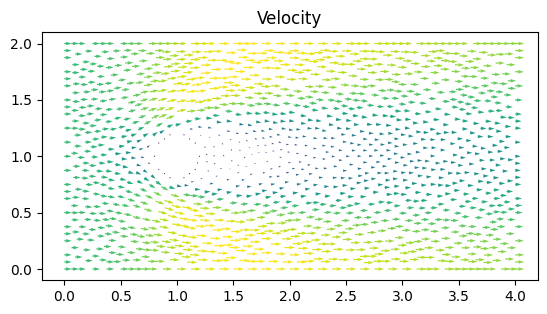

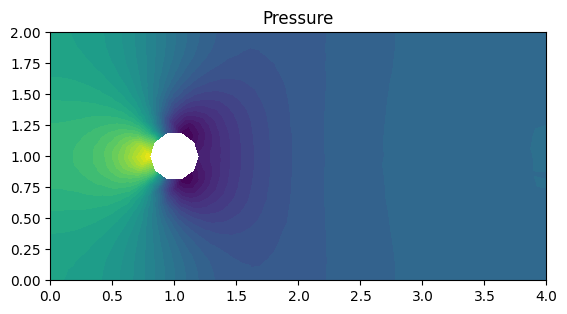

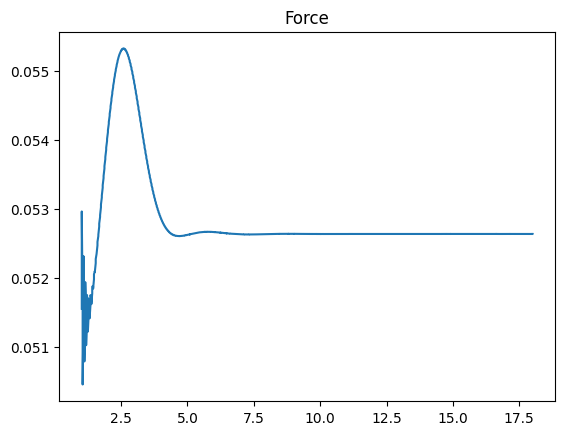

Time t = 21.027239472961604


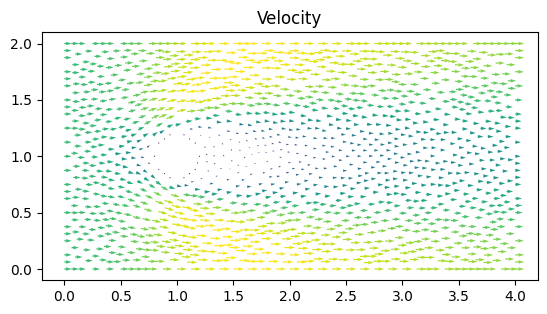

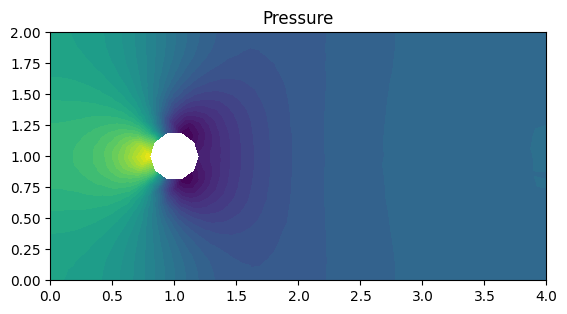

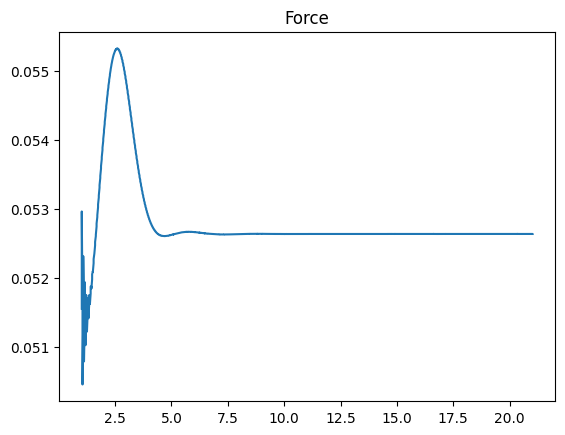

Time t = 24.017050085523426


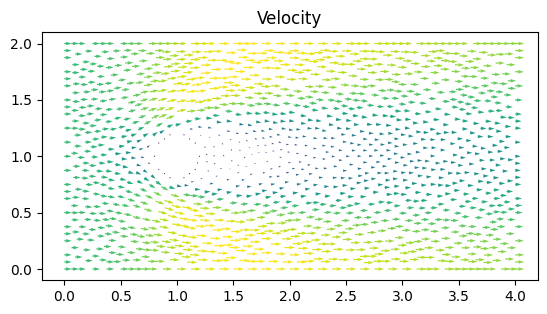

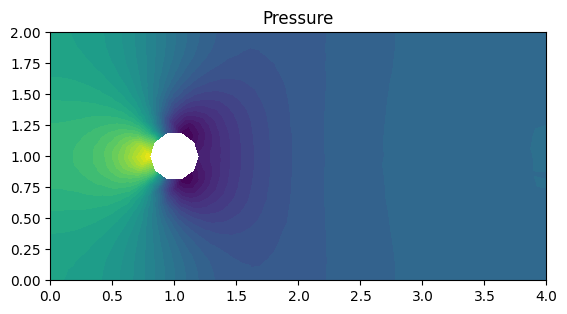

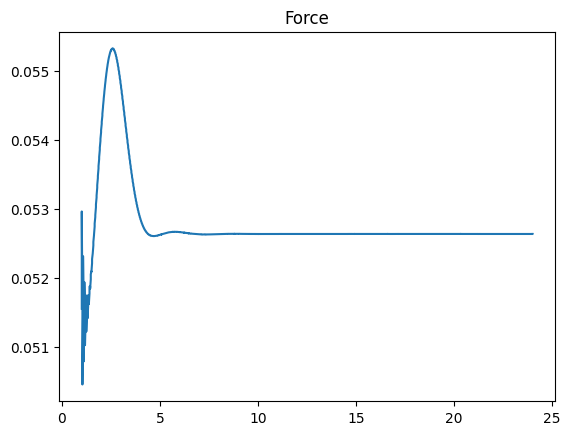

Time t = 27.006860698085248


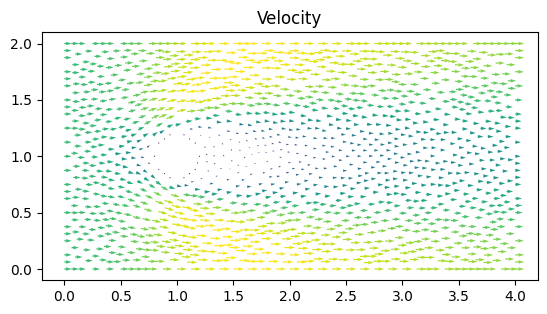

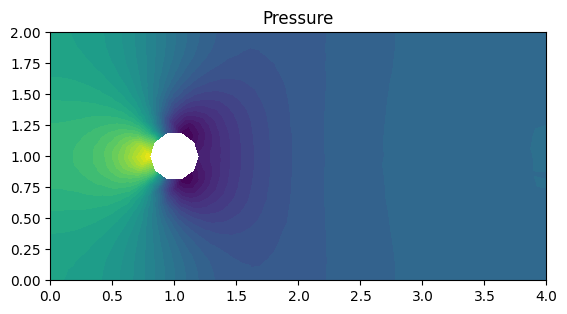

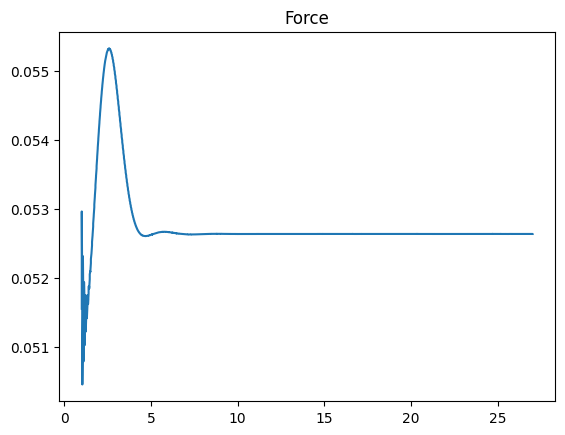

0.05275044710056084
Drag / Lift coefficent: 0.2637522355028042


In [ ]:
!rm results-NS/*


# Time stepping
T = 30
t = dt
while t < T + DOLFIN_EPS:

    #s = 'Time t = ' + repr(t)
    #print(s)

    pin.t = t
    #uin.t = t

    # Solve non-linear problem
    k = 0
    while k < num_nnlin_iter:

        # Assemble momentum matrix and vector
        Au = assemble(au)
        bu = assemble(Lu)

        # Compute velocity solution
        [bc.apply(Au, bu) for bc in bcu]
        [bc.apply(u1.vector()) for bc in bcu]
        solve(Au, u1.vector(), bu, "bicgstab", "default")

        # Assemble continuity matrix and vector
        Ap = assemble(ap)
        bp = assemble(Lp)

        # Compute pressure solution
        [bc.apply(Ap, bp) for bc in bcp]
        [bc.apply(p1.vector()) for bc in bcp]
        solve(Ap, p1.vector(), bp, "bicgstab", prec)

        # Compute force
        F = assemble(Force)
        if (t > start_sample_time):
          force_array = np.append(force_array, normalization*F)
          time = np.append(time, t)


        k += 1

    if t > plot_time:

        s = 'Time t = ' + repr(t)
        print(s)



        # Save solution to file
        file_u << u1
        file_p << p1

        # Plot solution
        plt.figure()
        plot(u1, title="Velocity")

        plt.figure()
        plot(p1, title="Pressure")

        plot_time += T/plot_freq

        plt.show()

        plt.figure()
        plt.title("Force")
        plt.plot(time, force_array)
        plt.show()


    # Update time step
    u0.assign(u1)
    t += dt



FD = np.mean(force_array)
print(FD)

# Drag and lift coefficient
CD = (2 * FD) / (1 * uin**2 * D)
print("Drag / Lift coefficent:", CD)







#!tar -czvf results-NS.tar.gz results-NS
#files.download('results-NS.tar.gz')

# **Discussion**

A stabilized finite element method was implemented in FEniCS to solve the Navier-Stokes equations in 2D. The method was tested for the model problem of flow past a circular obstacle, and for a high enough Reynolds number and sufficient mesh resolution [a von Karman vortex street developed as expected.](https://en.wikipedia.org/wiki/Kármán_vortex_street)

**Question 1 :** I computed the Reynolds number and I decided to change the viscosity to make it vary because if I changed the velocity, I encountered an issue when I wanted Re = 1000.

In the end, I find that for Re=1 and Re=10, the flow is steady, and for Re=100 and Re=1000, the flow is unsteady. Indeed, for these last two Reynolds numbers, the drag and lift force oscillates, they are not constant over time.

For Re = 1 :
![Re100_1](https://drive.google.com/uc?export&id=10VPrIG1B-6QgnUpdv8XRBv4Yb9t25tSW)![Re100_2](https://drive.google.com/uc?export&id=1tPjlEBwpvevWkC7O0dopfv2EgbbDBp4A)![Re100_2](https://drive.google.com/uc?export&id=1Wpt6jvcpMrSCsGr29ct0uUcVZ9Dooob1)

For Re = 10 :
![Re100_1](https://drive.google.com/uc?export&id=15eiY6_VbaEvgov5H_mLHgwP-oam5524C)![Re100_2](https://drive.google.com/uc?export&id=1tls5e6-EaaaVihlzTH4ynWeFExX6IEZL)![Re100_2](https://drive.google.com/uc?export&id=1NOlMozZEGwcJATDtgh3kc7fiTo3fUc8y)

For Re = 100 :
![Re100_1](https://drive.google.com/uc?export&id=1kpkcyt-Qpehs6-IOAUP2i9aUs1-ZW6CI)![Re100_2](https://drive.google.com/uc?export&id=1dZE7Hi82UienHlFkExHh9_-4teBXp29h)

For Re = 1000 :
![Re100_1](https://drive.google.com/uc?export&id=1hReNQz_eMHTJ_kw0Q85QzXB-JdeDs39K)![Re100_2](https://drive.google.com/uc?export&id=1SMQJtar-E1sb8g_Z2Wb7zdnahhTU05Qj)


**Question 2 :** The drag and lift coefficient are computed. The formula is the same, but if the initial conditions are changed, we compute or the drag or the lift force.

We compute the drag and lift coefficient for the different Reynolds numbers and we obtain :

Re = 1 : cd = 88.57940703172058 and cl = 0.1892226806277708

Re = 10 : cd = 18.02796098136303 and cl = 0.26375224780092743

Re = 100 : cd = 8.530069583746496 and cl = 0.20219847072708327

Re = 1000 : cd = 7.779862406622844 and cl = 0.2832737517287354


Now, we want to calculate the Strouhal number for the von Karman vortex street. On the plot of the force, we can count the number of periods, then we divide the time by this number of periods to have the time of a period and then we can obtain the frequency. And then we can have the Strouhal number.

$
T = \frac{27-1}{12} = 2.17s, \quad f = \frac{1}{T} = 0.46 Hz
$

So, $
St = \frac{fD}{U} = 0.185
$



**Question 3 :**    
For Re = 100, we now change the mesh resolution to study the effect on the drag and lift coefficent and the Strouhal number.

Results :    

Resolution = 1/8 : cd = 14.942891685396903 ; cl = -0.280617697069592 ; St = 0 (no oscillation)

Resolution = 1/16 : cd = 10.343794542315893 ; cl = 0.03718964002519129 ; St = 0.16

Resolution = 1/32 : cd = 8.530069583746496 ; cl = 0.20219844122210523 ; St = 0.185

I also try with 1/40 : cd = 5.126396880588203  ; cl = -0.620979091667852  ; St = 0.2   

Regarding these resultas, we can say that increasing the mesh quality improves the results of the drag and lift coefficients as well as the Strouhal number. The precision is better.